In [1]:
# demonstrate face detection on 5 Celebrity Faces Dataset
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import savez_compressed
from keras.models import load_model
from random import choice


from os.path import isdir
from mtcnn.mtcnn import MTCNN

import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


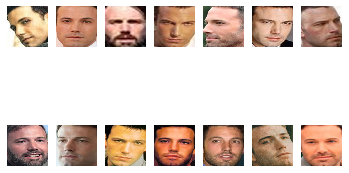

In [2]:


# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# specify folder to plot
folder = '5-celebrity-faces-dataset/train/ben_afflek/'
i = 1
# enumerate files
for filename in listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face(path)
	print(i, face.shape)
	# plot
	pyplot.subplot(2, 7, i)
	pyplot.axis('off')
	pyplot.imshow(face)
	i += 1
pyplot.show()

In [3]:
# face detection for the 5 Celebrity Faces Dataset



# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

# load train dataset
trainX, trainy = load_dataset('5-celebrity-faces-dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('5-celebrity-faces-dataset/val/')
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 14 examples for class: ben_afflek
>loaded 17 examples for class: elton_john
>loaded 21 examples for class: jerry_seinfeld
>loaded 19 examples for class: madonna
>loaded 22 examples for class: mindy_kaling
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: madonna
>loaded 5 examples for class: mindy_kaling


In [4]:


# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
Imodel = load_model('facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(Imodel, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(Imodel, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


C:\Users\Sumit\.conda\envs\su\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loaded Model
(93, 128)
(25, 128)


In [5]:
# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=93, test=25
Accuracy: train=100.000, test=100.000


In [6]:
# develop a classifier for the 5 Celebrity Faces Dataset



Predicted: elton_john (91.707)
Expected: elton_john


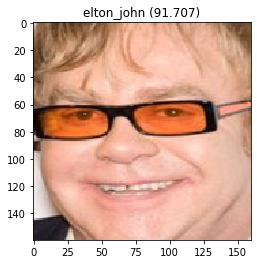

In [7]:



# load faces
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']

# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)

print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

In [8]:
#for prediction

In [9]:
from PIL import Image
#load image
gg=Image.open('5-celebrity-faces-dataset/val/jerry_seinfeld/httpblognjcomentertainmentimpactcelebritiesmediumjerrybjpg.jpg')


# convert to RGB, if needed
gg = gg.convert('RGB')
# convert to array
pixels = asarray(gg)

In [10]:

# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
results = detector.detect_faces(pixels)


In [11]:
results

[{'box': [55, 62, 115, 162],
  'confidence': 0.9999414682388306,
  'keypoints': {'left_eye': (86, 130),
   'right_eye': (135, 126),
   'nose': (112, 161),
   'mouth_left': (90, 184),
   'mouth_right': (140, 180)}}]

In [12]:
# extract the bounding box from the first face
x1, y1, width, height = results[0]['box']
# bug fix
x1, y1 = abs(x1), abs(y1)
x2, y2 = x1 + width, y1 + height
# extract the face
face = pixels[y1:y2, x1:x2]
# resize pixels to the model size
gg = Image.fromarray(face)
gg = gg.resize((160,160))
testface_array = asarray(gg)

In [13]:
testface_array.shape

(160, 160, 3)

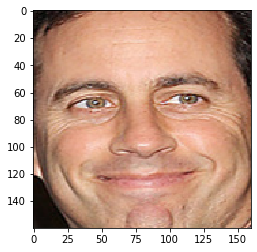

In [14]:
pyplot.imshow(testface_array)

In [15]:
Imodel=load_model('facenet_keras.h5')

C:\Users\Sumit\.conda\envs\su\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [16]:
# prediction for the face
gg = expand_dims(testface_array, axis=0)
ggemb = Imodel.predict(gg)


In [17]:
ggemb

array([[ 0.41992927,  0.43725   ,  0.2786754 ,  0.82537717,  0.5823403 ,
         0.5786684 ,  1.5215805 , -0.39705896, -0.49094266, -1.935808  ,
         1.2320415 , -1.6678678 , -1.1000417 ,  1.3977823 , -1.9154463 ,
        -0.586741  ,  1.0507823 , -0.57869726, -0.4594881 ,  0.22574538,
        -0.49869505, -1.4104905 ,  0.79438126,  0.99721813,  0.58127004,
         1.5029453 ,  1.7299852 ,  0.04680732, -0.17541917, -1.4800729 ,
         0.48877898,  1.6961416 , -0.28218457, -0.04452876, -0.69364005,
         0.6200248 ,  1.3628585 , -0.8169674 ,  0.81625974,  0.42625836,
        -0.95522046, -0.73205984,  0.36609662, -1.1055094 , -0.35243237,
         0.99340916,  0.64926904, -0.19671625, -1.1729296 , -0.75672424,
         1.5750973 , -0.2147859 ,  1.6116531 ,  1.1137642 , -0.29371318,
         3.3925512 , -0.19413286, -1.9316478 ,  1.7505112 ,  1.3474606 ,
        -0.654292  ,  1.6582744 ,  1.2376881 ,  0.17069767, -0.15023914,
         0.98894024,  1.3641303 ,  0.8890505 ,  0.8

In [18]:
yp=model.predict(ggemb)

In [19]:
yp

array([1], dtype=int64)

In [20]:
model.predict_proba(ggemb)

array([[0.00142605, 0.51237401, 0.41176142, 0.01401634, 0.06042218]])

In [21]:
gg.shape

(1, 160, 160, 3)

In [22]:
def predict(pixels1):
    # detect faces in the image
    results1 = detector.detect_faces(pixels1)
    # extract the bounding box from the first face
    x1, y1, width, height = results1[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face1 = pixels1[y1:y2, x1:x2]
    # resize pixels to the model size
    '''gg1 = Image.fromarray(face1)'''
    gg1=array_to_img(face1)
    gg1 = gg1.resize((160,160))
    testface_array1 = asarray(gg1)
    # prediction for the face
    gg1 = expand_dims(testface_array1, axis=0)
    ggemb1 = Imodel.predict(gg1)
    
    yp=model.predict(ggemb1)
    
    return yp

In [23]:
print(predict(pixels))

[1]


In [24]:
#NORMALIZE AND USE THE PIXEL AND USE

#REAL TIME


In [25]:
while True:
    frame =cv2.VideoCapture(0)
    ret, img = frame.read()

    if ret:
        img = cv2.resize(img, (360,240))
        #img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imshow('Main', img)
        
        #test=load_img(path, grayscale=False ,target_size=(150,150))
        test1 = img_to_array(img)
        #print(test1)
        #img=img/255
        print(predict(test1))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

#camera.release()
cv2.destroyAllWindows()
            

[2]


IndexError: list index out of range